In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, localize_inloc, visualization

# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the [InLoc dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/inloc/`, or change the path.

In [ ]:
dataset = Path('datasets/inloc/')  # change this if your dataset is somewhere else

pairs = Path('pairs/inloc/')
loc_pairs = pairs / 'pairs-query-netvlad40.txt'  # top 40 retrieved by NetVLAD

outputs = Path('outputs/inloc/')  # where everything will be saved
results = outputs / 'InLoc_hloc_superpoint+superglue_netvlad40.txt'  # the result file

In [ ]:
# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [ ]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_file = f"{features}.h5"
match_file = f"{features}_{matcher_conf['output']}_{loc_pairs.stem}.h5"

## Extract local features for database and query images

In [ ]:
extract_features.main(feature_conf, dataset, outputs)

## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [ ]:
match_features.main(matcher_conf, loc_pairs, features, outputs)

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. Different from when localizing with Aachen, here we do not need a 3D SfM model here: the dataset already has 3D lidar scans. The file `InLoc_hloc_superpoint+superglue_netvlad40.txt` will contain the estimated query poses.

In [ ]:
localize_inloc.main(
    dataset,
    loc_pairs,
    outputs / feature_file,
    outputs / match_file,
    results,
    skip_matches=20)  # skip database images with too few matches

## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

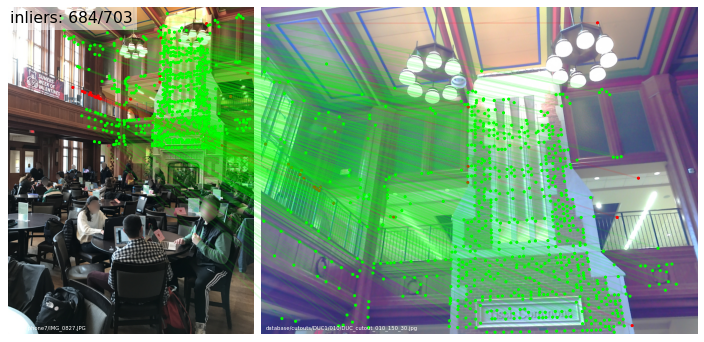

In [21]:
visualization.visualize_loc(results, dataset, n=1, top_k_db=1, seed=2)